In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
# import model_evaluation as me DEPRECATED
import random
import os
import cv2
from PIL import Image
import torch.nn.functional as F
from load_data import load_dataset
from model_helper import ModelHelper

"""
Set to true if you want to train yourself, false if you plan to load the model from file (trained_models/...)
"""
train_locally = False

In [2]:

data_dir = 'data'

full_dataset = load_dataset(data_dir=data_dir)


In [3]:
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self, num_classes=3):  # 3 Klassen: normal, Alzheimer, Parkinson
        super(CNNModel, self).__init__()
        self.layers = nn.Sequential(
            # Convolutional-Schicht: 3 Eingabekanäle (RGB), 16 Filter, 5x5 Kernel
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolutional-Schicht: 16 Eingabekanäle, 32 Filter, 3x3 Kernel
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            
            # Fully Connected-Schicht
            nn.Linear(16 * 56 * 56, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout für Regularisierung
            
            # Fully Connected-Schicht, die zu Klassen führt
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

# Create the model and use an optimizer with a tuned learning rate
model = CNNModel(num_classes=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with an initial learning rate
criterion = nn.CrossEntropyLoss()  # loss function for classification


# Model summary for confirmation
from torchsummary import summary
summary(model, (3, 224, 224))
model


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 226, 226]             448
              ReLU-2         [-1, 16, 226, 226]               0
         MaxPool2d-3         [-1, 16, 113, 113]               0
            Conv2d-4         [-1, 16, 113, 113]           2,320
              ReLU-5         [-1, 16, 113, 113]               0
         MaxPool2d-6           [-1, 16, 56, 56]               0
           Flatten-7                [-1, 50176]               0
            Linear-8                  [-1, 256]      12,845,312
              ReLU-9                  [-1, 256]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                    [-1, 3]             771
Total params: 12,848,851
Trainable params: 12,848,851
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

CNNModel(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=50176, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [5]:

# (CPU oder GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if train_locally:
    modelHelper = ModelHelper(model, full_dataset, device, batch_size=2048)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(modelHelper.model.parameters(), lr=0.001)
    
    modelHelper.train_model(criterion, optimizer, num_epochs=11)
    modelHelper.evaluate_model()
    modelHelper.save_model()
    
else:
    filename = 'models/CNN_20241104_1905-96.31.pth'
    modelHelper = ModelHelper.load_model(filename)
    modelHelper.evaluate_model()


Test Accuracy: 96.93%, Test Loss: 0.0916


In [7]:
log_file_path = "model_benchmark.log"
test_results = modelHelper.model.val(data=modelHelper.test_dataset)
speed_metrics = test_results.speed
results_dict = test_results.results_dict

with open(log_file_path, "w") as log_file:
    log_file.write("Model Validation Benchmark\n")
    log_file.write("=" * 40 + "\n\n")

    log_file.write("Speed Metrics (ms):\n")
    for key, value in speed_metrics.items():
        log_file.write(f"  {key}: {value:.2f}\n")  # Format values to 2 decimal places
    log_file.write("\n")

    log_file.write("Evaluation Metrics:\n")
    for key, value in results_dict.items():
        log_file.write(f"  {key}: {value}\n")  # Write each metric
    log_file.write("\n")

print(f"Model benchmarks saved to {log_file_path}")

AttributeError: 'CNNModel' object has no attribute 'val'

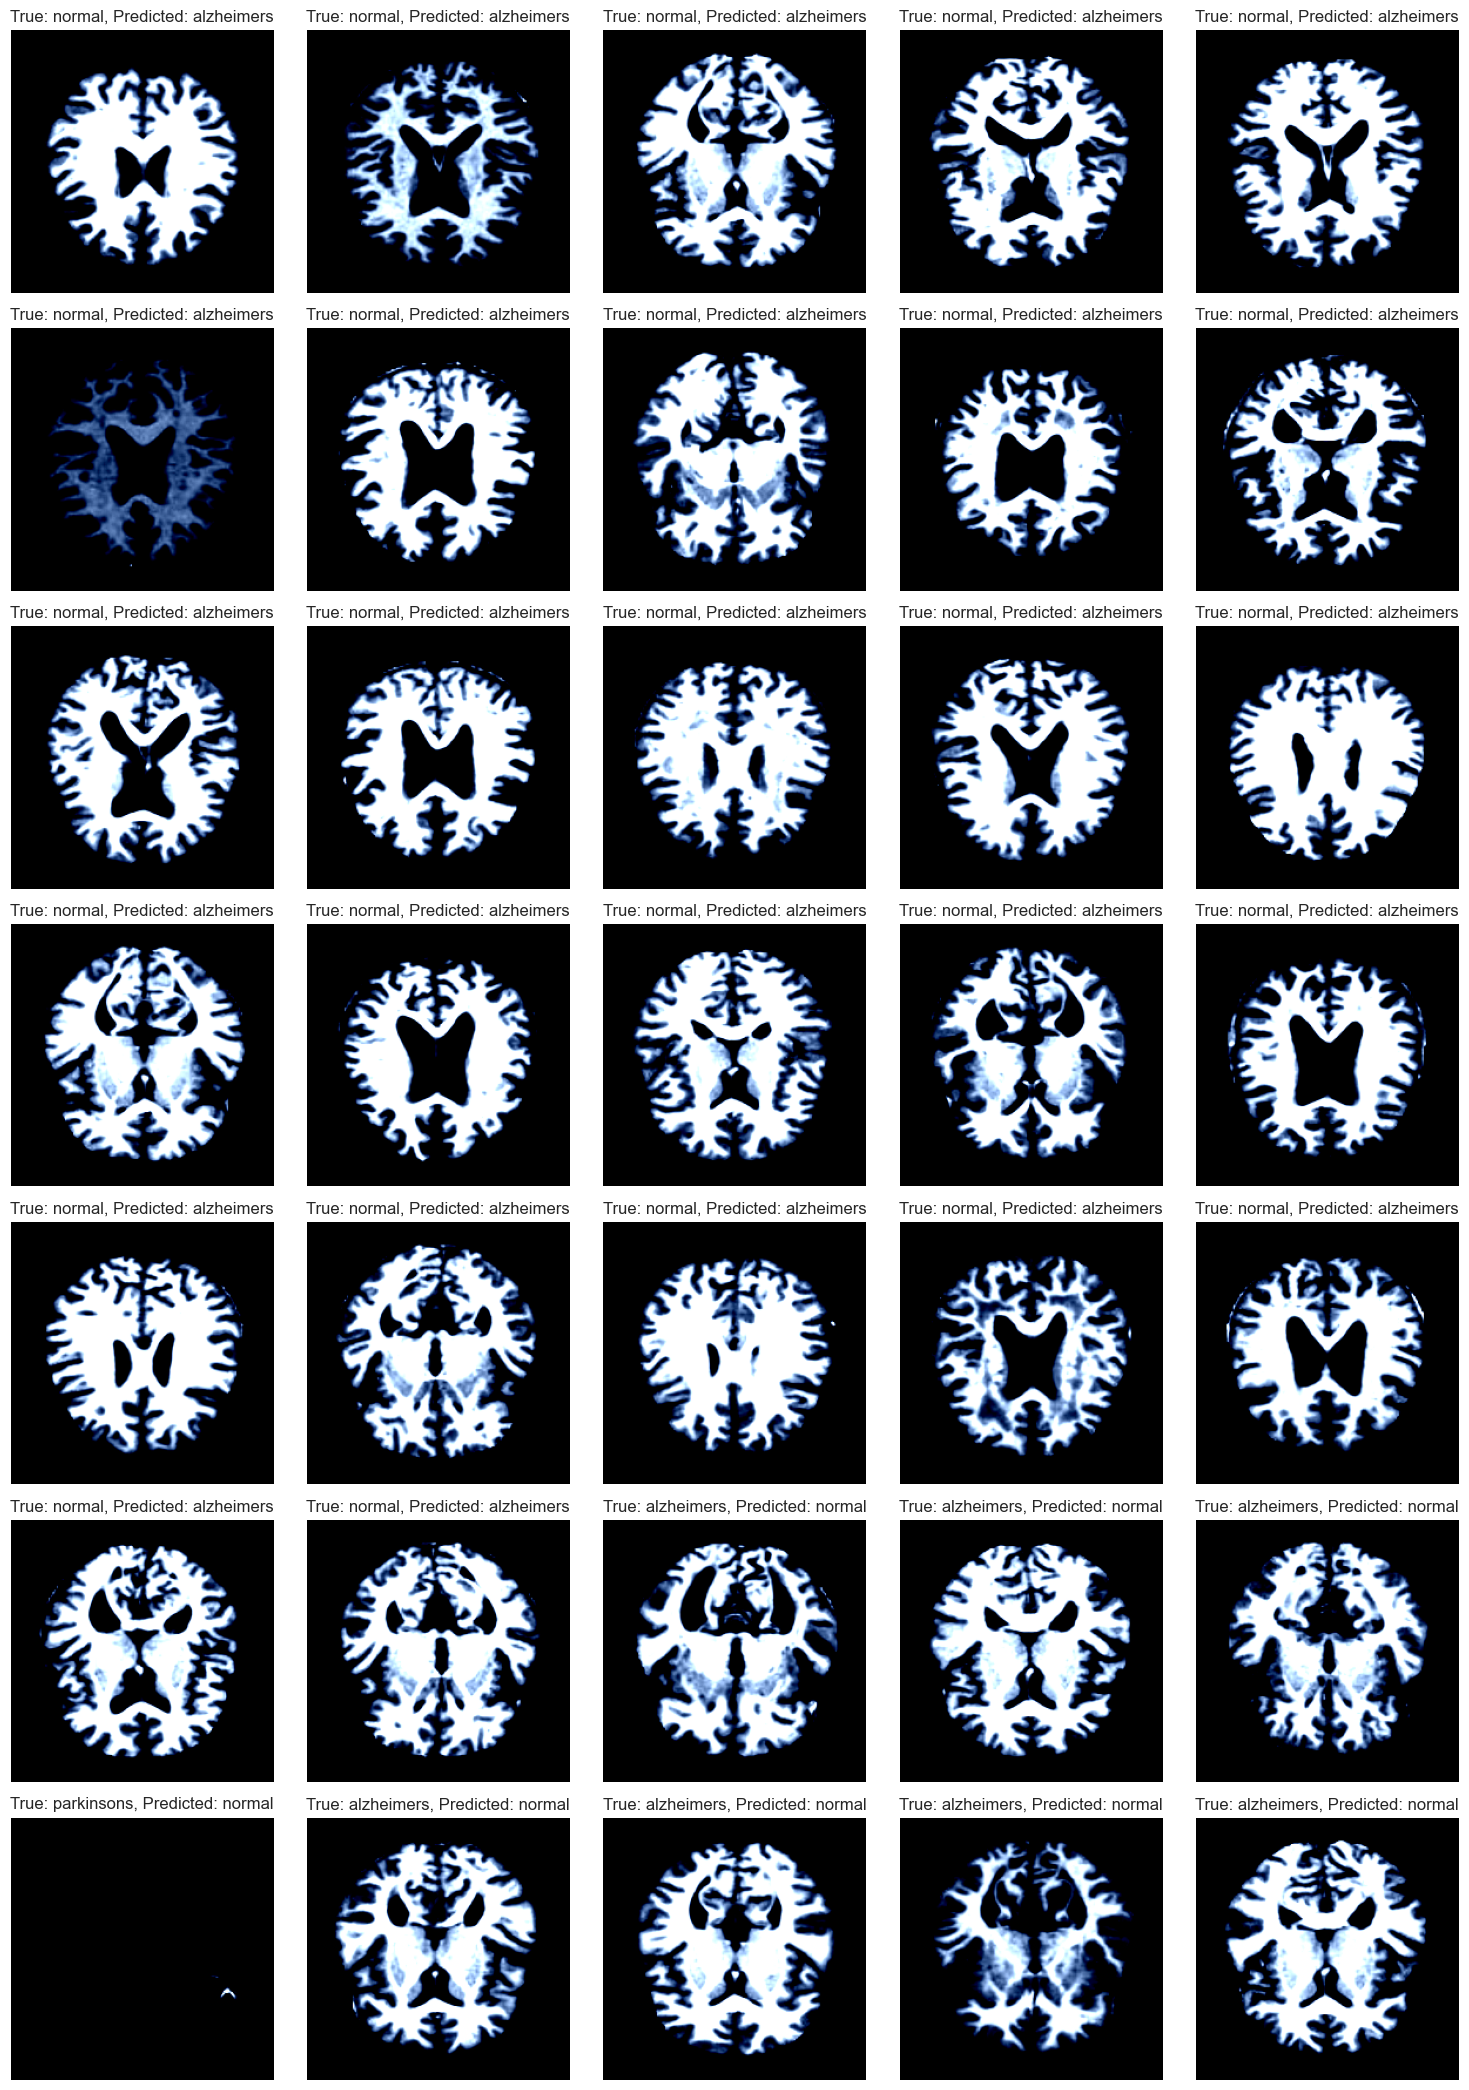

In [5]:
modelHelper.plot_incorrect_images()

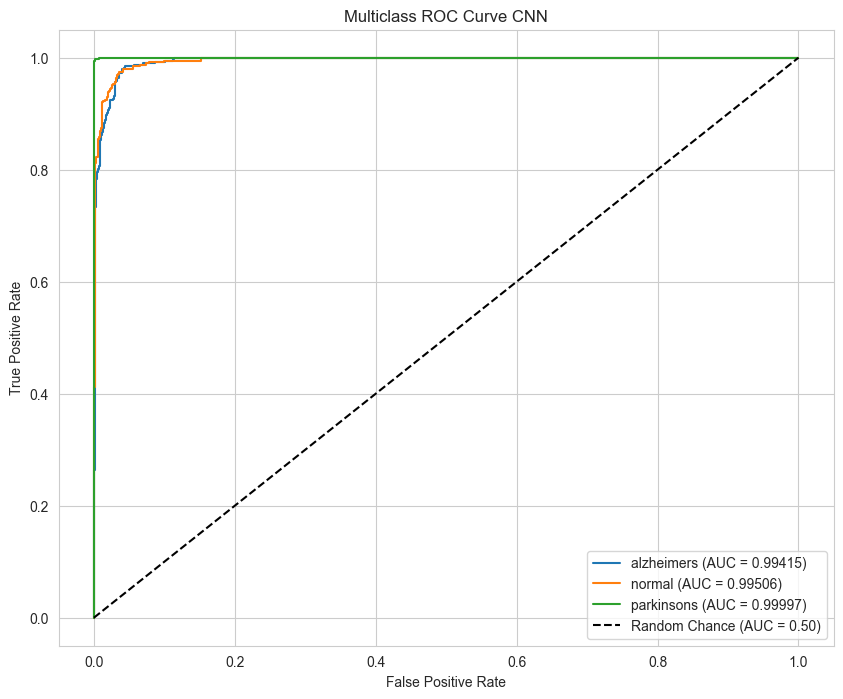

In [6]:
modelHelper.plot_multiclass_roc()

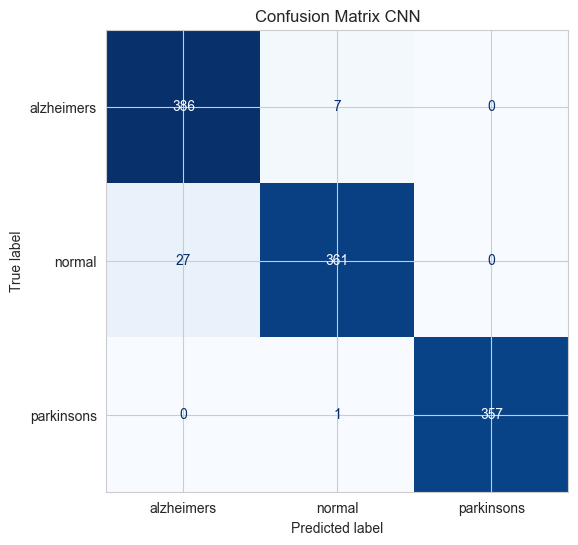

In [7]:
modelHelper.plot_confusion_matrix()

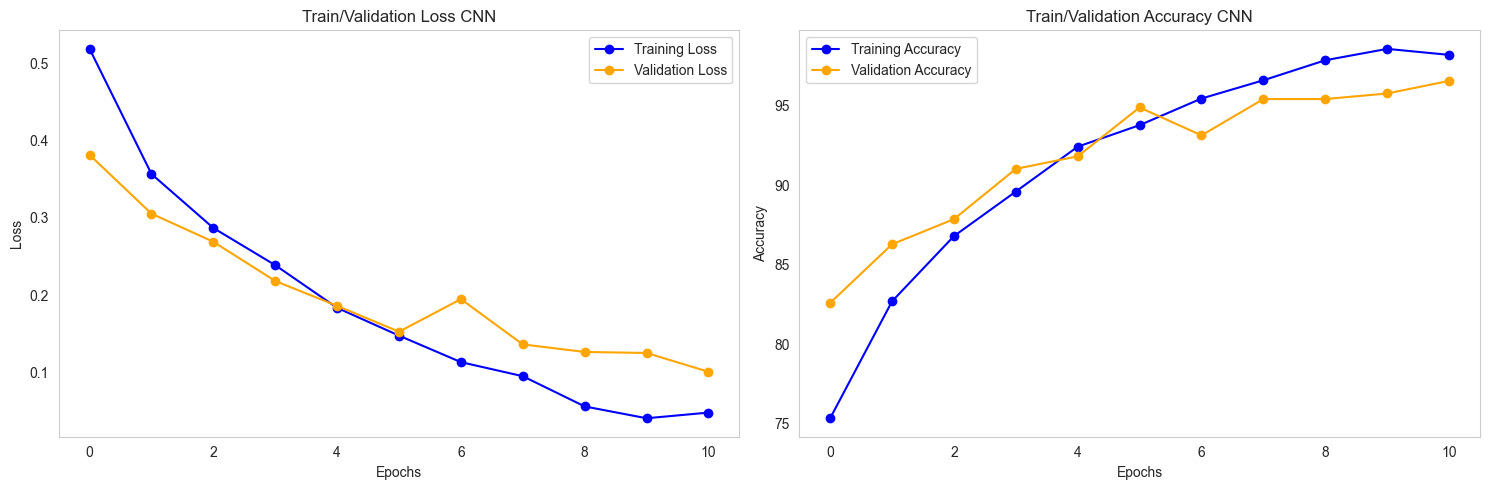

In [8]:
modelHelper.plot_losses_and_accuracies()

Folder: data/normal


C:\Users\rapha\FHNW\DataScience II\Pitch\neurodegenerativediseases_datascience2\venv\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


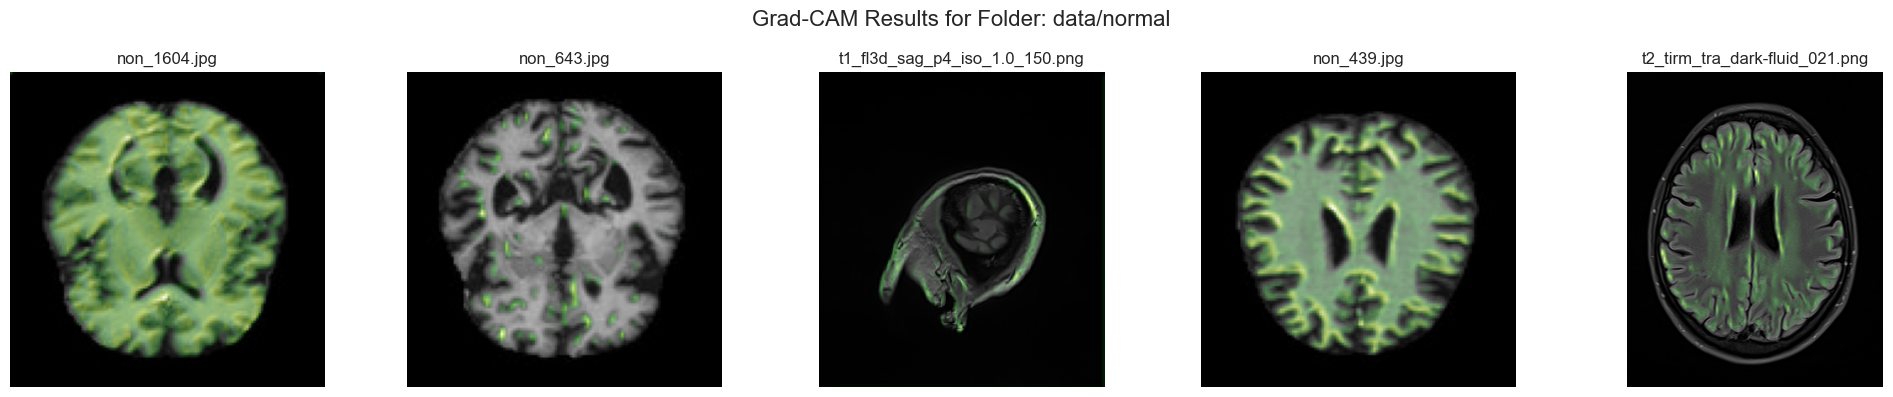

Folder: data/parkinsons_dataset


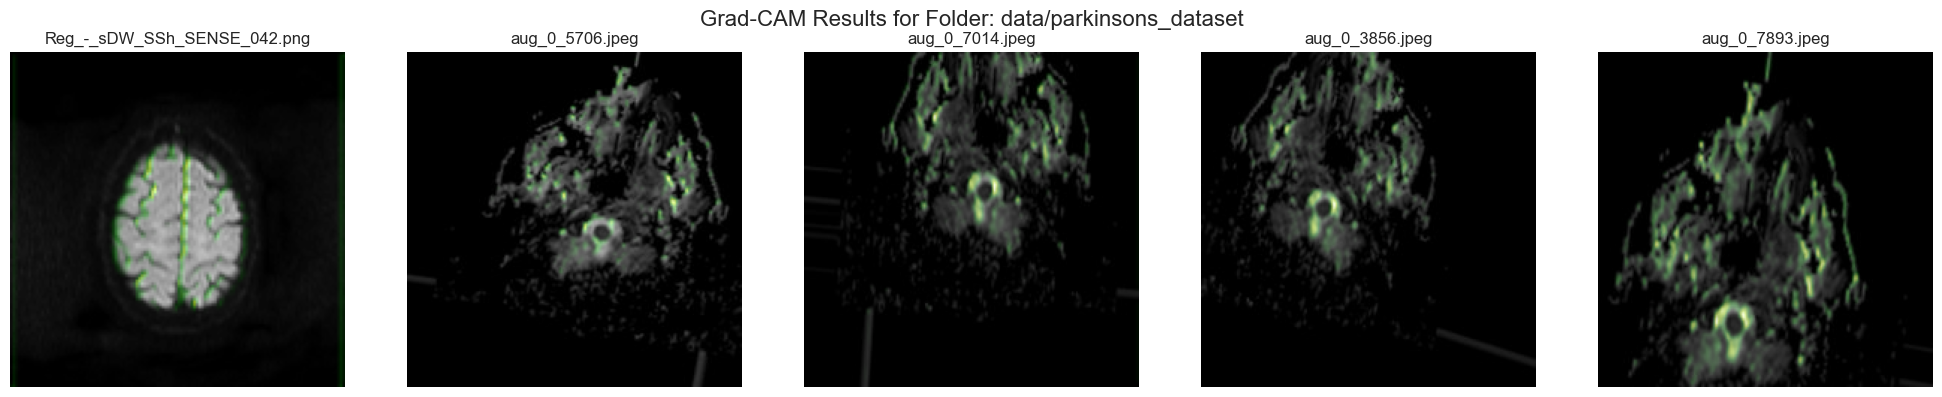

Folder: data/alzheimers_dataset


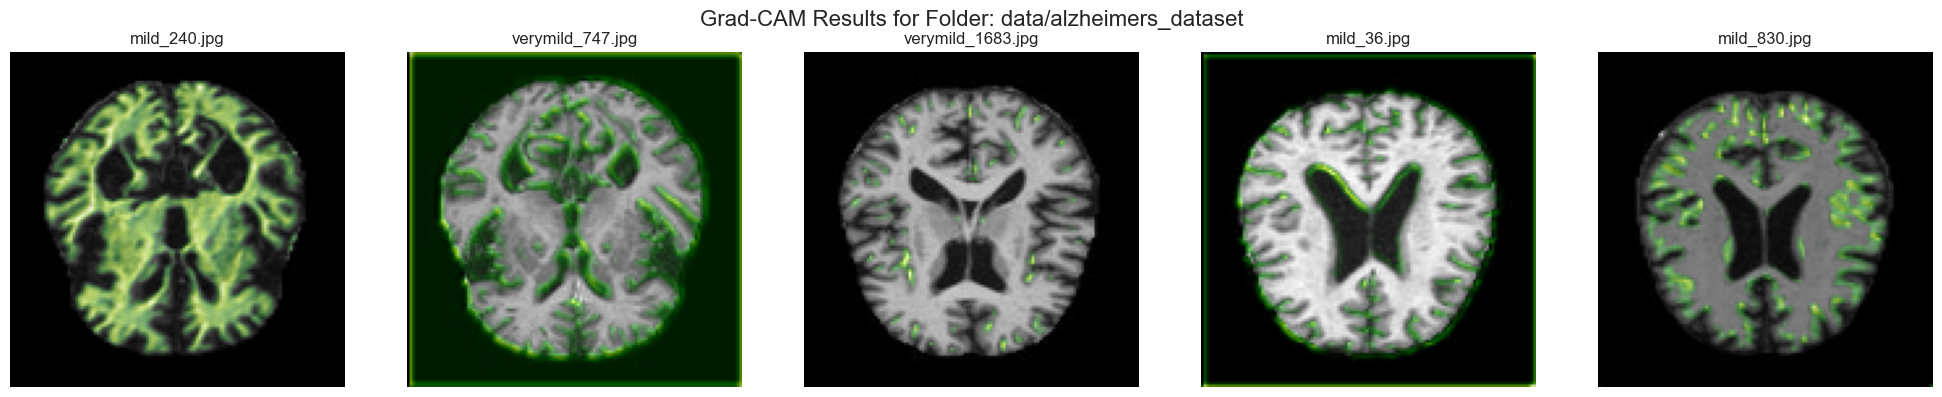

In [9]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        
        # Hooks zur Registrierung der Gradienten und Feature Maps
        self.forward_hook = self.target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = self.target_layer.register_backward_hook(self.save_gradient)  # Verwende backward_hook
    
    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate_cam(self, input_image, class_idx=None):
        self.model.eval()
        output = self.model(input_image)

        if class_idx is None:
            class_idx = torch.argmax(output).item()

        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        gradients_mean = self.gradients.mean(dim=(2, 3), keepdim=True)
        weighted_activation = (gradients_mean * self.activation).sum(dim=1, keepdim=True)
        
        cam = F.relu(weighted_activation).squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        
        # Remove hooks to avoid memory leaks
        self.forward_hook.remove()
        self.backward_hook.remove()
        
        return cam

def apply_gradcam(model, layer_name, input_image, class_idx=None):
    grad_cam = GradCAM(model, target_layer=layer_name)
    cam = grad_cam.generate_cam(input_image, class_idx=class_idx)
    return cam

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

def show_cam_on_image(img, cam, alpha=0.5):
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_DEEPGREEN)  # Optional: Colormap angepasst
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img)
    overlay = overlay / np.max(overlay)
    return overlay

# Funktion zur Auswahl zufälliger Bilder und Grad-CAM Anwendung mit 1x5 Anordnung
def apply_gradcam_to_random_images(model, layer_name, folders):
    for folder in folders:
        images = random.sample(os.listdir(folder), 5)
        print(f"Folder: {folder}")
        
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # 1x5 Raster
        
        for i, img_name in enumerate(images):
            image_path = os.path.join(folder, img_name)
            
            input_image = preprocess_image(image_path)
            cam = apply_gradcam(model, layer_name, input_image)
            
            original_img = cv2.imread(image_path)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) / 255.0
            
            overlay = show_cam_on_image(original_img, cam)
            
            axs[i].imshow(overlay)
            axs[i].set_title(img_name)
            axs[i].axis('off')
        
        plt.suptitle(f"Grad-CAM Results for Folder: {folder}", fontsize=16)
        plt.tight_layout()
        plt.show()

target_layer = modelHelper.model.layers[3]

folders = ['data/normal', 'data/parkinsons_dataset', 'data/alzheimers_dataset']

# Grad-CAM auf zufällige Bilder anwenden
apply_gradcam_to_random_images(modelHelper.model, target_layer, folders)